<h1>SI 670 Kaggle Competition 4</h1>

Team GSIs

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model, Sequential, layers
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input 

In [2]:
#tf.config.list_physical_devices('GPU')

<h2>Load datasets</h2>

In [3]:
len(list(os.listdir("../data/images_train/bathroom"))), len(list(os.listdir("../data/images_train/kitchen")))

(301, 315)

In [7]:
data = tf.keras.utils.image_dataset_from_directory("../data/images_train", 
                                                   image_size = (256, 256), 
                                                   class_names = ['bathroom', 'kitchen'], 
                                                   shuffle = True,
                                                   batch_size = 32)

Found 616 files belonging to 2 classes.


In [8]:
X, y = zip(*data)

X = np.concatenate(X)
y = np.concatenate(y)

In [9]:
len(X), len(y)

(616, 616)

<h2>Preprocess Images</h2>

In [11]:
#flip labels so bathroom is 1
y = np.where(y == 1, 0, 1)

In [12]:
X = np.apply_along_axis(lambda s: s / 255.0, axis = 1, arr = X)

<h2>Split</h2>

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = 42, test_size = 0.2)

<h2>Generate new training images</h2>

In [14]:
data_augmentation = Sequential([
    tf.keras.layers.RandomFlip("horizontal", input_shape=(256, 256, 3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
  ])

In [15]:
augmented_images = data_augmentation(X_train)

2023-11-19 17:16:53.212959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


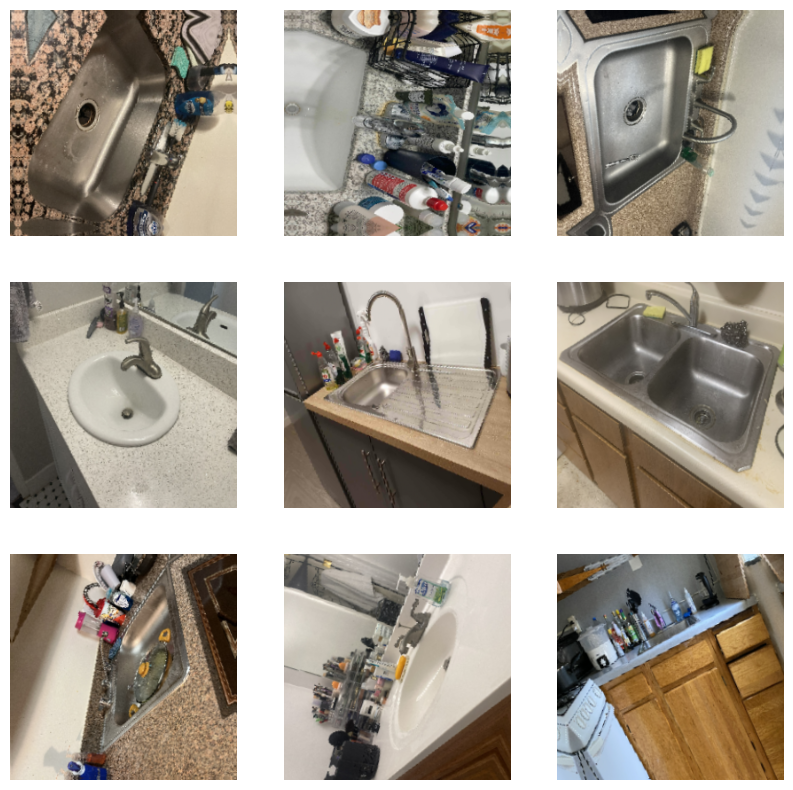

In [16]:
plt.figure(figsize = (10, 10))
for i, img in enumerate(augmented_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')

<h2>Train Model</h2>

In [32]:
base_model = tf.keras.applications.ResNet50(input_tensor = tf.keras.Input(shape = (256, 256, 3)),  include_top = False)

<h3>Set trainable layers</h3>

In [33]:
base_model.trainable = False
len(base_model.layers)

175

In [34]:
last_block_conv_layers = ['conv5_block3_3_conv', 'conv5_block3_2_conv', 'conv5_block3_1_conv']
for layer in base_model.layers:
    if 'conv5' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

In [35]:
#inputs = tf.keras.Input(shape = (256, 256, 3))
inputs = data_augmentation(X_train)
x = base_model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128)(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

model = Model(base_model.input, outputs)

2023-11-19 17:28:21.294248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


In [36]:
loss = BinaryCrossentropy()
opt = tf.keras.optimizers.legacy.Adam(learning_rate = 0.001)
model.compile(optimizer = opt, loss = loss, metrics = ['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 5, restore_best_weights = True)

model_history = model.fit(X_train, y_train, batch_size = 64,
                          epochs = 80,  
                          callbacks = [early_stopping], 
                          validation_data = (X_val, y_val))

Epoch 1/80
7/7 [==============================] - 11s 1s/step - loss: 70.0364 - accuracy: 0.5318 - val_loss: 61.1918 - val_accuracy: 0.4646
Epoch 2/80
7/7 [==============================] - 5s 744ms/step - loss: 27.6343 - accuracy: 0.5802 - val_loss: 606.5564 - val_accuracy: 0.4646
Epoch 3/80
7/7 [==============================] - 6s 817ms/step - loss: 8.2994 - accuracy: 0.6870 - val_loss: 2170.0735 - val_accuracy: 0.4646
Epoch 4/80
1/7 [===>..........................] - ETA: 5s - loss: 7.4013 - accuracy: 0.6406

In [ ]:
model.save("../saved_weights/haley_submit_8")

<h2>Test Model</h2>

In [30]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 2s 442ms/step - loss: 0.4666 - accuracy: 0.8065


[0.46655192971229553, 0.8064516186714172]

In [31]:
model.evaluate(X_val, y_val)

4/4 [==============================] - 1s 383ms/step - loss: 0.4925 - accuracy: 0.7677


[0.49254539608955383, 0.7676767706871033]

In [ ]:
y_pred_prob = model.predict(X_test)

In [ ]:
y_pred_class = np.where(y_pred_prob > 0.5, 1, 0).flatten()

In [ ]:
matrix = confusion_matrix(y_pred_class, y_test)

In [ ]:
normalized_confusion_matrix = matrix / matrix.astype(float).sum(axis = 1)[:, np.newaxis]

In [ ]:
f = sns.heatmap(normalized_confusion_matrix, annot = True)
f.set(title = 'Normalized Confusion Matrix', xlabel = 'True', ylabel = 'Predicted')
plt.savefig("../plots/haley_heatmap_submission7.png")

<h2>Make Prediction</h2>

In [ ]:
pred_data = tf.keras.utils.image_dataset_from_directory("../data/images_test", image_size = (256, 256), labels = None)
pred_data = pred_data.unbatch()
pred_images = [img / 255.0 for img in pred_data]

In [ ]:
imgs = []
ids = []

for f in os.listdir("../data/images_test"):
    img = tf.keras.utils.load_img(os.path.join("../data/images_test", f), target_size = (256, 256, 3))
    img = tf.keras.utils.img_to_array(img) / 255.0
    id = f.split(".")[0]
    ids.append(id)
    imgs.append(img)

In [ ]:
predictions = model.predict(np.array(np.array(imgs)))

<h2>Format predictions for submission</h2>

In [ ]:
class_predictions = np.where(predictions > 0.5, 1, 0).flatten()

In [ ]:
df = pd.DataFrame({'id': ids, 'class': class_predictions})

In [ ]:
df.to_csv("../submissions/submit_7.csv", index = None)